In [24]:
import re

with open("data/PAP.md", "r") as f:
    md = f.read()

# Extract IDs and split pages
ids = re.findall(r'(?m)^PAP\s+(\d+)\b', md)
pages = re.split(r'(?m)^PAP\s+\d+\b', md)[1:]
pages = [re.sub(r'\|\|\|\|(\w+)\|\|\|\|', r'\1', p.strip()) for p in pages]

print("Pages:", len(pages), "| IDs:", len(ids))
print(pages[0][:200])

Pages: 56 | IDs: 56
Ma 293 A variety of mob-madness to which we all seem to be more or less subject is manifested in taking up vague opinions about which our associates and companions seem strenuous. I am apt, in some mo


In [25]:
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Load small English model without unnecessary components
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

# Process all pages
docs = list(nlp.pipe(pages, batch_size=50, n_process=2))

# Extract clean lemmas (nouns and proper nouns only)
def get_terms(doc):
    return [
        tok.lemma_.lower()
        for tok in doc
        if tok.is_alpha and tok.pos_ in {"NOUN", "PROPN"} and len(tok.lemma_) > 2
    ]

texts = [" ".join(get_terms(doc)) for doc in docs]

# Build TF-IDF matrix
tfidf = TfidfVectorizer(min_df=2, max_df=0.9, dtype=np.float32)
X = tfidf.fit_transform(texts)

print("TF-IDF shape:", X.shape)

TF-IDF shape: (56, 232)


UMAP embedding shape: (56, 2)


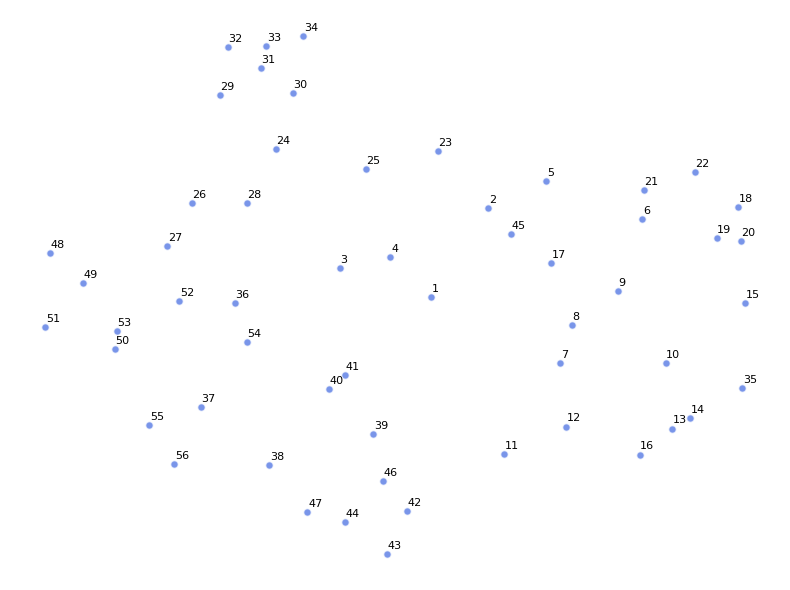

In [26]:
import matplotlib.pyplot as plt # type: ignore

# Compute UMAP
reducer = umap.UMAP( # type: ignore
    n_neighbors=15,
    min_dist=0.1,
    metric="cosine",
    random_state=42
)
emb = reducer.fit_transform(X)
print("UMAP embedding shape:", emb.shape)

# Draw
plt.figure(figsize=(8, 6))
plt.scatter(emb[:, 0], emb[:, 1], s=30, c='royalblue', alpha=0.7, edgecolors='white')

for i, pid in enumerate(ids):
    plt.text(emb[i, 0] + 0.005, emb[i, 1] + 0.04, pid, fontsize=8, color='black')

# Remove everything extra
plt.axis('off')
plt.tight_layout()
plt.show()